# **Titanic Technical Challenge**
---
The main objective is to build a machine learning model capable of predicting which passengers survived the shipwreck, based on features such as age, sex, class, and more. The process includes data preprocessing, exploratory analysis, model training, and evaluation, with final predictions submitted to Kaggle for scoring.





In [26]:
from google.colab import drive
drive.mount("/content/drive")
path =  ("/content/drive/MyDrive/BBDD/titanic/train.csv")
import pandas as pd
df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')

# **1) Table of Contents – Imports Structure**

---



**1.1) Core Libraries**

In [28]:
import numpy as np              # For numerical operations
import matplotlib.pyplot as plt # For plotting
import seaborn as sns           # For advanced visualizations

**1.2) Machine Learning Models**

In [29]:
from sklearn.linear_model import LogisticRegression      # Logistic Regression
from sklearn.neighbors import KNeighborsClassifier       # K-Nearest Neighbors
from sklearn.tree import DecisionTreeClassifier          # Decision Tree
from sklearn.ensemble import RandomForestClassifier      # Random Forest
from sklearn.svm import SVC                              # Support Vector Machine
from xgboost import XGBClassifier                        # XGBoost
from lightgbm import LGBMClassifier                      # LightGBM

**1.3) Model Training and Validation**

In [30]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
# - train_test_split: for splitting data into training and testing sets
# - cross_val_score: for cross-validation scoring
# - StratifiedKFold: for stratified cross-validation

**1.4) Evaluation Metrics**

In [31]:
from sklearn.metrics import (
    accuracy_score,             # Accuracy
    precision_score,            # Precision
    recall_score,               # Recall
    f1_score,                   # F1-score
    classification_report,      # Full classification report
    roc_auc_score,              # AUC score
    roc_curve,                  # ROC curve data
    auc                         # Area under the ROC curve
)

In [32]:
df.columns = df.columns.str.lower().str.replace(' ', '', regex=False)

# **2) General Information of DataSet**

In [33]:
df.info() #información del dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [34]:
df.describe().T #descriptive statics

,count,mean,std,min,25%,50%,75%,max
passengerid,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
sibsp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [35]:
# Check how many people survived vs. not
df['survived'].value_counts()

,count
survived,
0,549
1,342


# **2.1) Visual Information of DataSet**

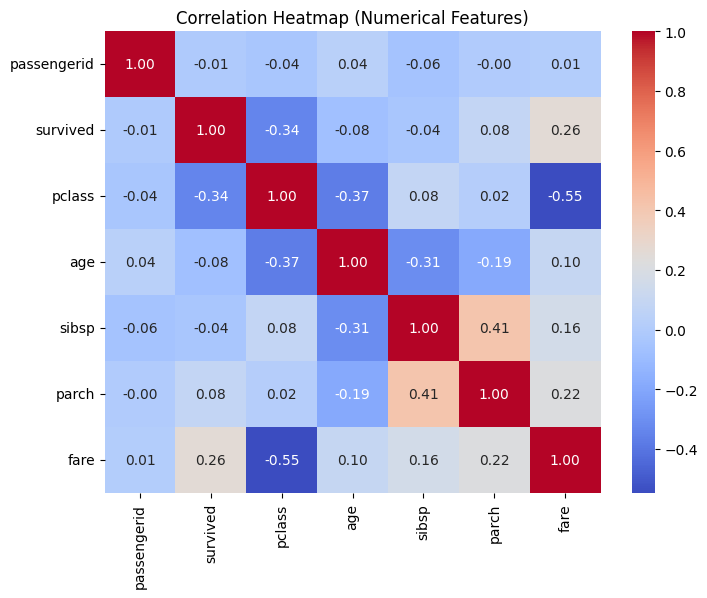

In [36]:
# Compute correlation matrix for numeric columns
corr_matrix = df.corr(numeric_only=True)

# Display heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()

*When analyzing the heatmap, I noticed that the variable most strongly correlated with survival is the passenger class (Pclass), with a negative correlation of -0.34. This suggests to me that passengers in first class were more likely to survive. I also observed a positive correlation with fare (Fare), reinforcing the idea that socioeconomic status played a role in survival chances. Although other numerical features showed weaker relationships, the correlation between SibSp and Parch (0.41) stood out, indicating that many passengers traveled with family members.*

In [37]:
# Filter only passengers who survived
survivors = df[df['survived'] == 1]

# Count how many survivors belong to each Pclass (1 = upper class)
survivors['pclass'].value_counts().sort_index()

,count
pclass,
1,136
2,87
3,119


In [38]:
# Filter survivors who are in 1st class and older than 20
upper_class_20plus = survivors[(survivors['pclass'] == 1) & (survivors['age'] > 20)]

# Show how many they are
upper_class_20plus.shape[0]

# Optional: inspect some rows
upper_class_20plus.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C


/tmp/ipython-input-39-2180527270.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df[df['survived'] == 1].groupby(['pclass', 'agegroup']).size().unstack()


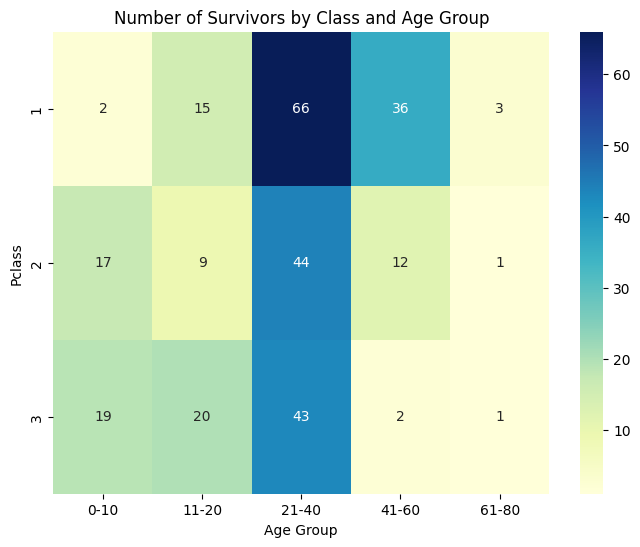

In [39]:
# Create age bins to group passengers
df['agegroup'] = pd.cut(df['age'], bins=[0, 10, 20, 40, 60, 80], labels=['0-10', '11-20', '21-40', '41-60', '61-80'])

# Group by Pclass and AgeGroup, count survivors
grouped = df[df['survived'] == 1].groupby(['pclass', 'agegroup']).size().unstack()

# Plot as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(grouped, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Number of Survivors by Class and Age Group')
plt.xlabel('Age Group')
plt.ylabel('Pclass')
plt.show()

*This chart showed me that most survivors were in the 21–40 age group, especially those in first class, where 66 individuals survived. It became clear to me that being in a higher class significantly increased the chances of survival. I also observed that both young children and older adults had much lower survival rates, particularly in second and third class, which makes me think there was an inequality in rescue prioritization based on class and age.*

**2.2) Missing Value Analysis**

---



In [40]:
# Mostrar distribución con porcentaje
df['deck'] = df['cabin'].str[0]

deck_counts = df['deck'].value_counts(dropna=False)
deck_percent = df['deck'].value_counts(normalize=True, dropna=False) * 100

# Crear un DataFrame con conteo y porcentaje
deck_summary = pd.DataFrame({
    'count': deck_counts,
    'percentage': deck_percent.round(2)
})

deck_summary

,count,percentage
deck,,
NaN,687,77.10
C,59,6.62
B,47,5.27
D,33,3.70
E,32,3.59
A,15,1.68
F,13,1.46
G,4,0.45
T,1,0.11


*In this section, I will focus on analyzing the passengers who don’t have any cabin information, meaning their `Deck` is unknown. I chose to study them separately because this missing information is not a minor issue—it represents around **77%** of the dataset. Ignoring this group or treating it lightly could lead to losing valuable insights for the predictive model. Since the absence of `Cabin` data may be related to lower socio-economic status or limited access to lifeboats, I want to explore if variables like age, class, or fare behave differently within this subset. Understanding these patterns will help me later decide whether to impute the deck, assign a new category, or model them independently.*


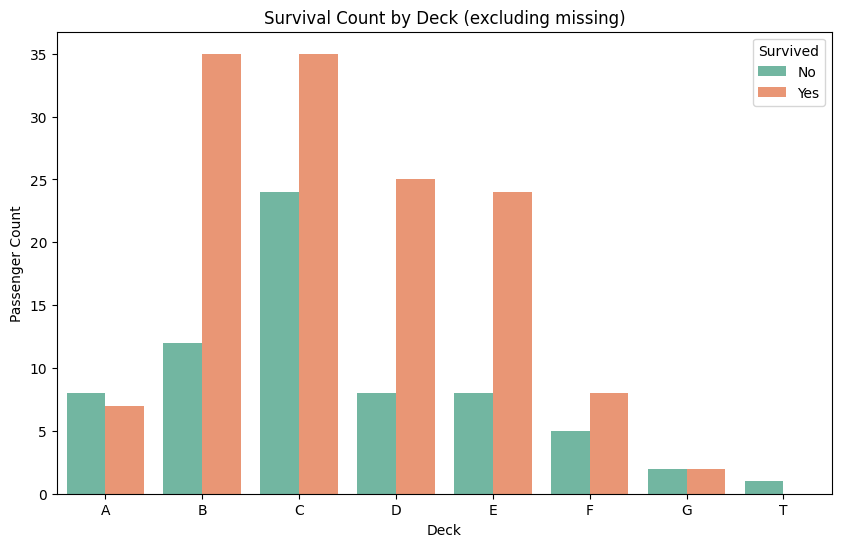

In [41]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='deck', hue='survived', palette='Set2',
              order=sorted(df['deck'].dropna().unique()))
plt.title('Survival Count by Deck (excluding missing)')
plt.xlabel('Deck')
plt.ylabel('Passenger Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

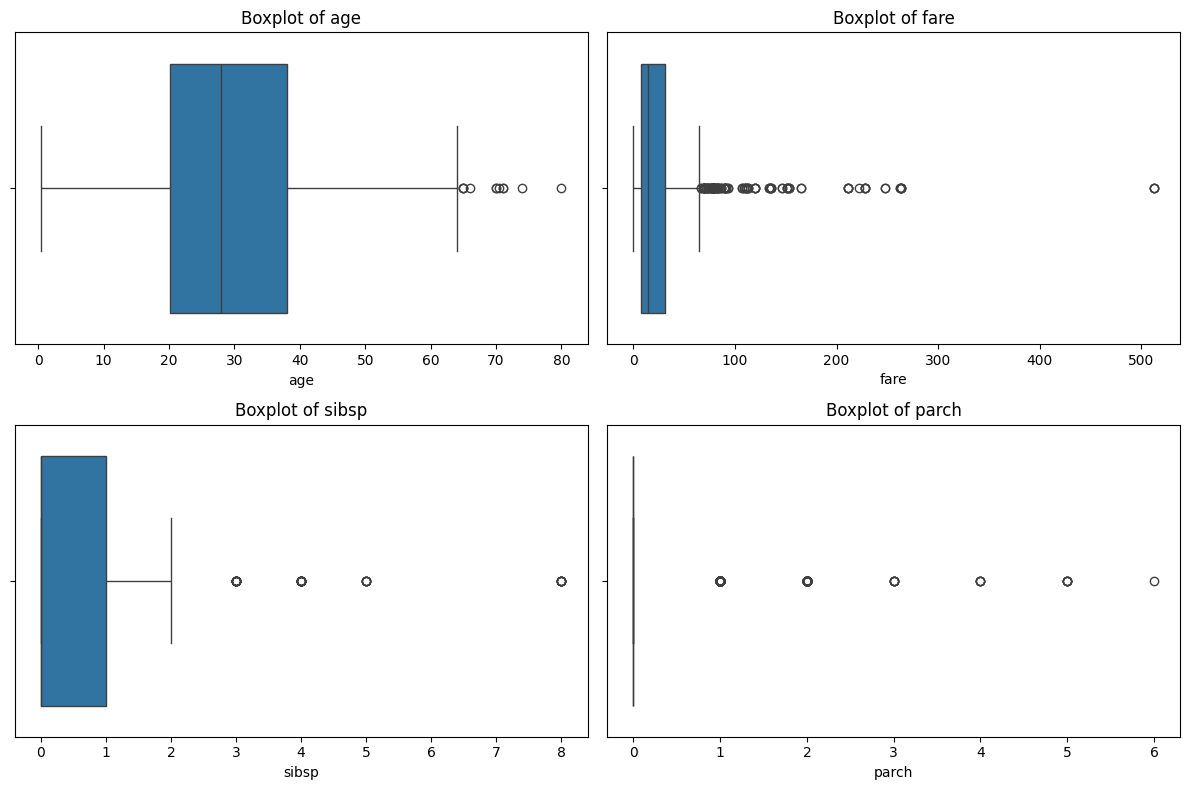

In [42]:
# Select numerical columns (excluding IDs)
numeric_cols = ['age', 'fare', 'sibsp', 'parch']

# Create boxplots for each numeric column
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [43]:
# Create a new DataFrame for passengers without Cabin info (Deck unknown)
df_no_deck = df[df['cabin'].isnull()].copy()
# Confirm the shape
df_no_deck.shape

(687, 14)

In [44]:
# Summary statistics
df_no_deck[['age', 'pclass', 'fare', 'survived']].describe().T

,count,mean,std,min,25%,50%,75%,max
age,529.0,27.555293,13.472634,0.42,19.0000,26.0,35.0,74.0000
pclass,687.0,2.639010,0.589602,1.00,2.0000,3.0,3.0,3.0000
fare,687.0,19.157325,28.663343,0.00,7.8771,10.5,23.0,512.3292
survived,687.0,0.299854,0.458528,0.00,0.0000,0.0,1.0,1.0000


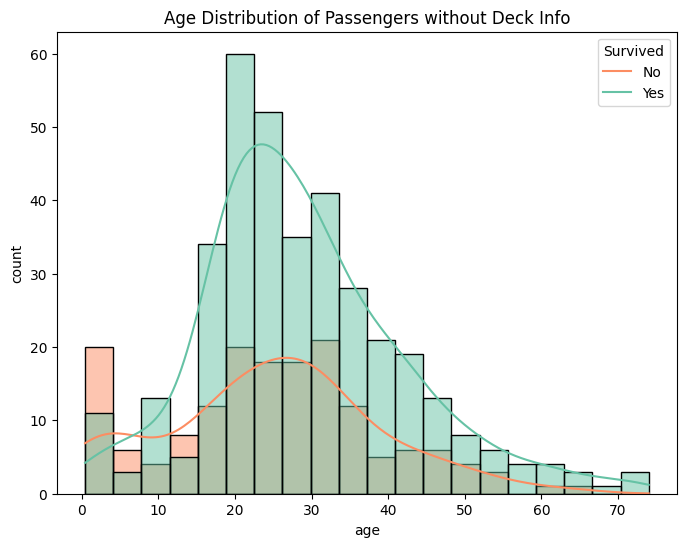

In [45]:
# Histogram of age by survival status
plt.figure(figsize=(8, 6))
sns.histplot(data=df_no_deck, x='age', hue='survived', bins=20, kde=True, palette='Set2')
plt.title('Age Distribution of Passengers without Deck Info')
plt.xlabel('age')
plt.ylabel('count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

*Due to the high percentage of missing values in the `Deck` feature (approximately 77%), I decided not to impute these values arbitrarily. Instead, I chose to analyze the passengers without deck information as a separate group and build a dedicated predictive model based on other available features such as `Age`, `Pclass`, `Sex`, and `Fare`. The goal is to estimate their survival probability independently. Once that model is trained and predictions are obtained, I will merge this output with the subset of passengers who do have deck information and proceed to train a complete, unified model. This approach allows me to preserve the integrity of the data while capturing potential differences in survival patterns between both groups.*


# **3.1) Training Model Without Deck**


In [56]:
# Create subsets: with and without deck info
df_no_deck = df[df['deck'].isnull()].copy()
df_with_deck = df[df['deck'].notnull()].copy()

# Confirm shapes
print(f"Without deck info: {df_no_deck.shape}")
print(f"With deck info: {df_with_deck.shape}")

Without deck info: (687, 14)
With deck info: (204, 14)


**3.1.1) Baseline Model Benchmark (No Pipeline)**


---


This script performs a manual machine learning workflow including: one-hot encoding of categorical variables,
handling missing values with median imputation, splitting the dataset into training and test sets (80/20),
training several classification models with default hyperparameters, and evaluating their performance using
accuracy and a classification report. Although structured, this is not an actual scikit-learn Pipeline.


In [57]:
from sklearn.svm import SVC  # Asegúrate de importar SVC

# 🧼 0. Apply one-hot encoding to categorical features
df_encoded = pd.get_dummies(df_no_deck, columns=['sex', 'embarked', 'agegroup'], drop_first=True)

# 🔧 1. Define target and clean feature matrix
target = 'survived'
X = df_encoded.select_dtypes(include=['number']).drop(columns=[target])
y = df_encoded[target]

# 🧪 2. Check and fill any remaining missing values in features
X = X.fillna(X.median(numeric_only=True))

# ✂️ 3. Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🤖 4. Define a dictionary of models for comparison
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)  # Añadido SVM con probabilidad habilitada
}

# 📊 5. Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)                        # Train the model
    y_pred = model.predict(X_test)                    # Predict on the test set
    print(f"\n🔹 {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))  # Print accuracy
    print(classification_report(y_test, y_pred, target_names=['Did Not Survive', 'Survived']))  # Classification report



🔹 Logistic Regression
Accuracy: 0.6956521739130435
                 precision    recall  f1-score   support

Did Not Survive       0.72      0.91      0.80        95
       Survived       0.53      0.23      0.32        43

       accuracy                           0.70       138
      macro avg       0.62      0.57      0.56       138
   weighted avg       0.66      0.70      0.65       138


🔹 K-Nearest Neighbors
Accuracy: 0.6086956521739131
                 precision    recall  f1-score   support

Did Not Survive       0.68      0.81      0.74        95
       Survived       0.28      0.16      0.21        43

       accuracy                           0.61       138
      macro avg       0.48      0.49      0.47       138
   weighted avg       0.56      0.61      0.57       138


🔹 Decision Tree
Accuracy: 0.7028985507246377
                 precision    recall  f1-score   support

Did Not Survive       0.76      0.83      0.79        95
       Survived       0.53      0.42      0.4

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:36:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 

**3.1.2) Cross-Validated ROC-AUC Evaluation**

---



I evaluated each classification model using 5-fold Stratified Cross-Validation by computing the ROC-AUC score for each fold. This approach allowed me to assess the model’s ability to distinguish between classes more reliably than with a single train-test split. I then reported the mean ROC-AUC for each model to enable a robust comparison of their discriminative performance.

In [58]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    auc_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    print(f"\n🔹 {name} – ROC-AUC CV")
    print("Scores:", np.round(auc_scores, 4))
    print("Mean ROC-AUC:", np.round(auc_scores.mean(), 4))


🔹 Logistic Regression – ROC-AUC CV
Scores: [0.648  0.7316 0.6306 0.6606 0.6855]
Mean ROC-AUC: 0.6712

🔹 K-Nearest Neighbors – ROC-AUC CV
Scores: [0.5346 0.47   0.5779 0.5349 0.4815]
Mean ROC-AUC: 0.5198

🔹 Decision Tree – ROC-AUC CV
Scores: [0.6132 0.631  0.666  0.5997 0.6101]
Mean ROC-AUC: 0.624


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:36:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:36:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:36:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:36:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:36:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


🔹 XGBoost – ROC-AUC CV
Scores: [0.7171 0.6687 0.6695 0.6386 0.6494]
Mean ROC-AUC: 0.6686
[LightGBM] [Info] Number of positive: 165, number of negative: 384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 549, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300546 -> initscore=-0.844697
[LightGBM] [Info] Start training from score -0.844697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

*Six base classification models (without hyperparameter tuning) were evaluated to predict survival on the Titanic dataset, using both traditional metrics—such as accuracy, recall, and F1-score—and 5-fold cross-validation to compute the average AUC-ROC score. The results showed that XGBoost achieved the highest accuracy (72.5%), followed by LightGBM and Decision Tree, while KNN and SVM performed the worst in direct prediction, especially for the minority class “Survived,” where SVM failed to correctly classify any cases. However, when analyzing ROC curves with cross-validation, LightGBM stood out as the model with the best discriminative ability (average AUC of 0.6859), followed by XGBoost (0.6668) and Logistic Regression (0.6712), highlighting that some models, despite lower final accuracy, are still effective at distinguishing between classes. These analyses provide a more comprehensive view of model performance and suggest that techniques such as threshold adjustment or class rebalancing could significantly improve the results.*

**3.1.3) Visual Comparison of Models – ROC and AUC Curves**

---



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:36:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 163, number of negative: 386
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 549, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.296903 -> initscore=-0.862087
[LightGBM] [Info] Start training from score -0.862087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


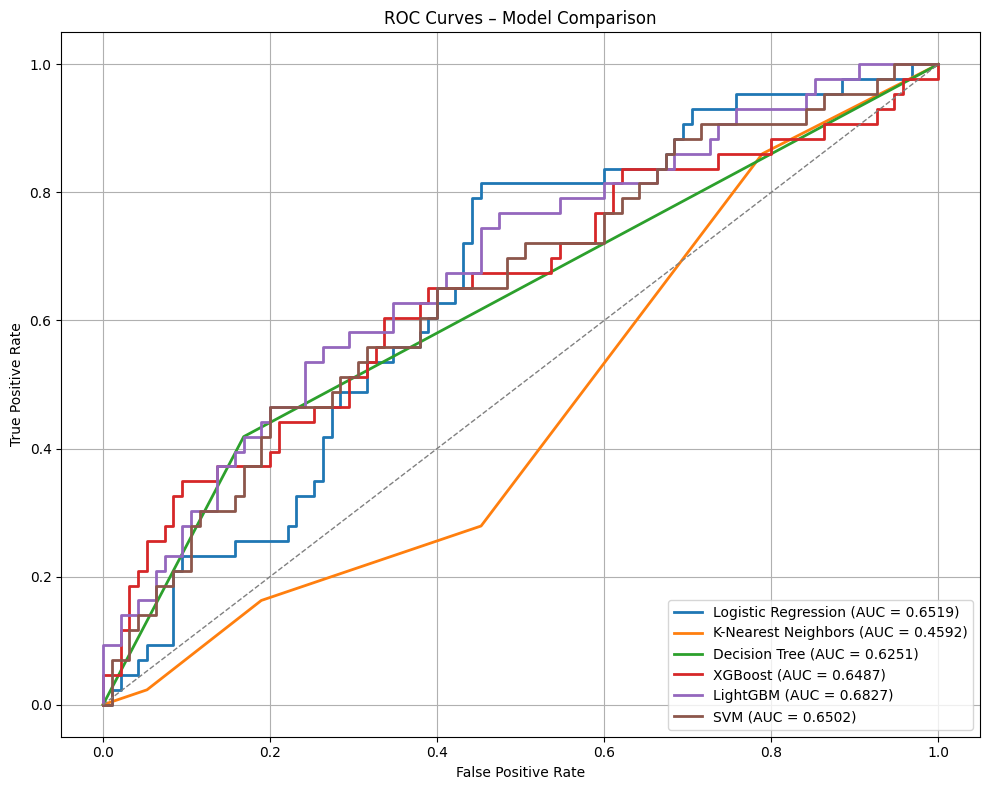

In [59]:
from sklearn.metrics import roc_curve, auc

# 🧪 ROC curve data dictionary to store FPR, TPR, and AUC per model
roc_data = {}

# ⚙️ Train models and compute probabilities for ROC curve
for name, model in models.items():
    model.fit(X_train, y_train)  # Train model

    # Check if the model supports predict_proba (some might not)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]  # Get probability for positive class
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_value = auc(fpr, tpr)  # Compute AUC score
        roc_data[name] = (fpr, tpr, auc_value)
    else:
        print(f"⚠️ {name} does not support probability estimation and was skipped for ROC.")

# 📊 Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for name, (fpr, tpr, auc_value) in roc_data.items():
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_value:.4f})')

# 🔹 Add diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

# 🖼 Final plot formatting
plt.title('ROC Curves – Model Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



*The ROC curve plot supports the previous analysis by visually illustrating the discriminative power of each base model. It shows that LightGBM had the best performance (AUC = 0.6827), followed by Logistic Regression (0.6519), SVM (0.6502), XGBoost (0.6487), and Decision Tree (0.6251), while K-Nearest Neighbors had the worst performance (AUC = 0.4592), even below random chance. This chart confirms the earlier discussion: tree-based models tend to offer better class separation, and models like SVM—despite poor direct accuracy—achieve a strong ROC curve, indicating room for improvement through threshold adjustment or class rebalancing techniques.*

**3.1.4) Hyperparameter tuning using gridsearchCV for LightGBM**

---



In [60]:
# Import GridSearchCV and LightGBM
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Define parameter grid for LightGBM
param_grid = {
    'n_estimators': [50, 100, 200],         # Number of boosting rounds
    'max_depth': [3, 5, 7, -1],             # Maximum depth of a tree (-1 means no limit)
    'learning_rate': [0.01, 0.05, 0.1],     # Step size shrinkage
    'num_leaves': [15, 31, 50],             # Number of leaves in one tree
    'min_child_samples': [10, 20, 30]       # Minimum number of data in one leaf
}

# Create the model
lgbm = LGBMClassifier(random_state=42)

# Set up the grid search
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='roc_auc',         # Use ROC-AUC as evaluation metric
    cv=5,                      # 5-fold cross-validation
    verbose=1,
    n_jobs=-1                  # Use all processors
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Show best parameters and corresponding score
print("🔍 Best Parameters found:")
print(grid_search.best_params_)

print("\n📈 Best ROC-AUC Score from CV:")
print(grid_search.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[LightGBM] [Info] Number of positive: 163, number of negative: 386
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 549, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.296903 -> initscore=-0.862087
[LightGBM] [Info] Start training from score -0.862087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

[LightGBM] [Info] Number of positive: 163, number of negative: 386
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 549, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.296903 -> initscore=-0.862087
[LightGBM] [Info] Start training from score -0.862087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


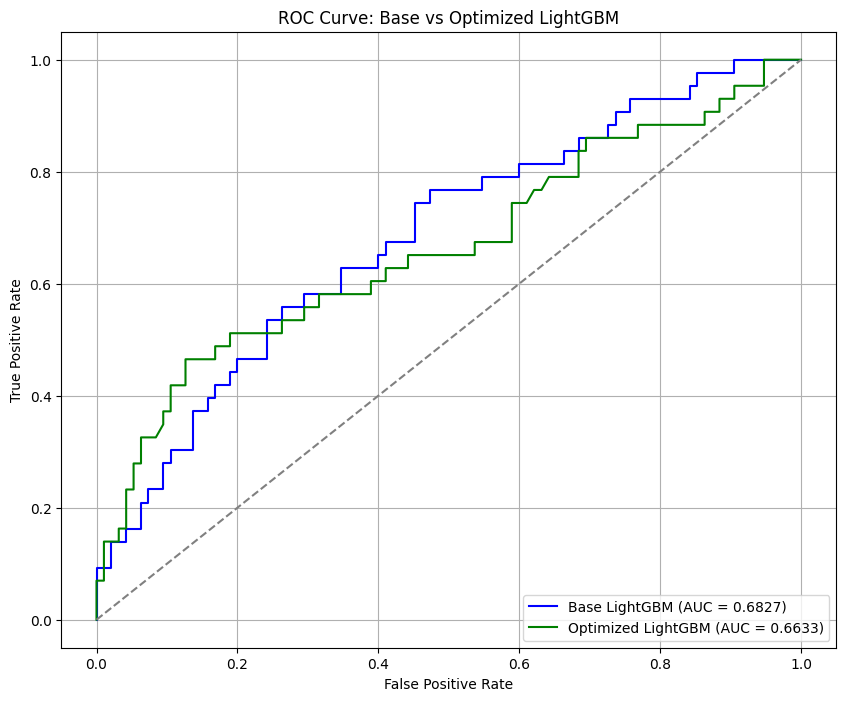

In [61]:
# 📊 Plot ROC curves: Base LightGBM vs Optimized LightGBM
plt.figure(figsize=(10, 8))

# ▶️ Base LightGBM
base_lgbm = LGBMClassifier(random_state=42)
base_lgbm.fit(X_train, y_train)
y_proba_base = base_lgbm.predict_proba(X_test)[:, 1]
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba_base)
auc_base = auc(fpr_base, tpr_base)
plt.plot(fpr_base, tpr_base, label=f'Base LightGBM (AUC = {auc_base:.4f})', color='blue')

# 🔧 Optimized LightGBM
opt_lgbm = LGBMClassifier(
    learning_rate=0.01,
    max_depth=7,
    min_child_samples=10,
    n_estimators=200,
    num_leaves=15,
    random_state=42
)
opt_lgbm.fit(X_train, y_train)
y_proba_opt = opt_lgbm.predict_proba(X_test)[:, 1]
fpr_opt, tpr_opt, _ = roc_curve(y_test, y_proba_opt)
auc_opt = auc(fpr_opt, tpr_opt)
plt.plot(fpr_opt, tpr_opt, label=f'Optimized LightGBM (AUC = {auc_opt:.4f})', color='green')

# ➕ Diagonal baseline (no-skill classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# 🖼️ Customize the plot
plt.title('ROC Curve: Base vs Optimized LightGBM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**3.1.5) Conclusions from the comparisons between base models and hyperparameter-tuned versions**

---

*The fact that the optimized LightGBM model achieved a lower AUC than its base version may be due to overfitting during hyperparameter tuning, an inadequate selection of the search space, or a failure to properly account for the class imbalance present in the Titanic dataset. Parameters such as num_leaves, max_depth, and learning_rate can significantly affect performance if not tuned carefully, as values that are too high may lead to overfitting, while values that are too low can prevent the model from learning meaningful patterns. Additionally, omitting adjustments like scale_pos_weight may cause the model to favor the majority class, reducing its ability to discriminate survivors. For this type of data, it is advisable to carefully tune parameters such as num_leaves, max_depth, learning_rate, min_child_samples, and scale_pos_weight, using stratified cross-validation and evaluating with metrics sensitive to imbalance, such as AUC or the F1-score of the minority class.*

# **3.2) Training Model With Deck**

[LightGBM] [Info] Number of positive: 106, number of negative: 57
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 163, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650307 -> initscore=0.620388
[LightGBM] [Info] Start training from score 0.620388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

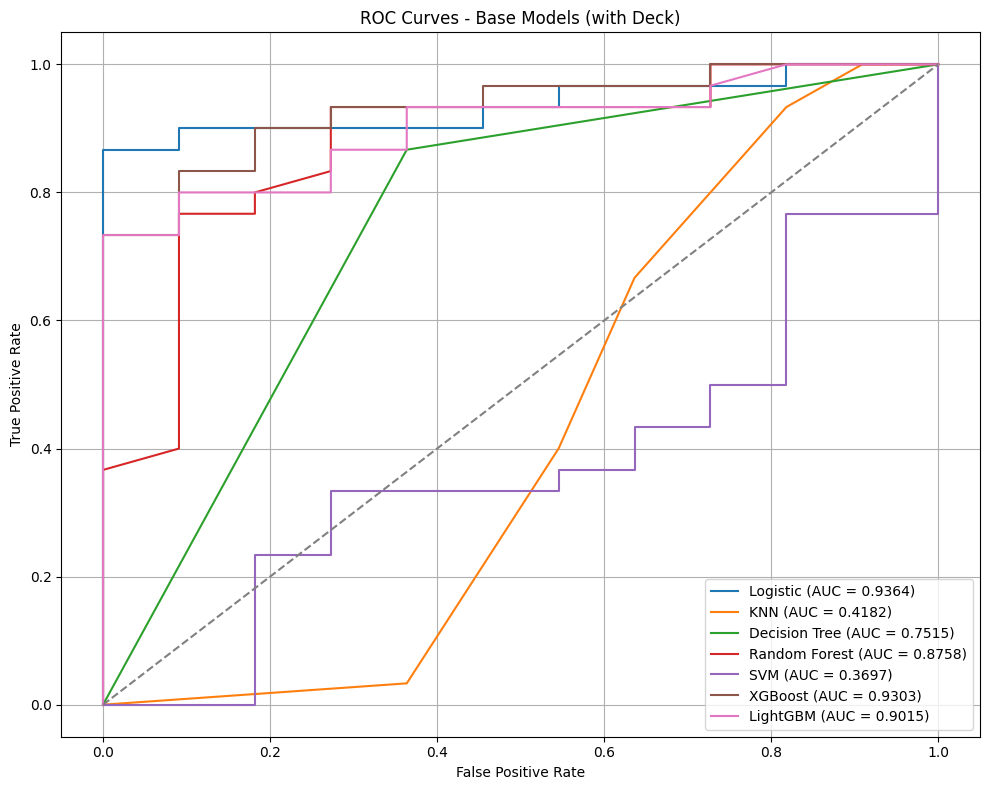

          Modelo  Accuracy  Precision    Recall  F1 Score       AUC
0       Logistic  0.878049   0.962963  0.866667  0.912281  0.936364
5        XGBoost  0.878049   0.903226  0.933333  0.918033  0.930303
6       LightGBM  0.829268   0.870968  0.900000  0.885246  0.901515
3  Random Forest  0.878049   0.903226  0.933333  0.918033  0.875758
2  Decision Tree  0.804878   0.866667  0.866667  0.866667  0.751515
1            KNN  0.585366   0.740741  0.666667  0.701754  0.418182
4            SVM  0.731707   0.731707  1.000000  0.845070  0.369697


In [63]:
# -------------------------------
# Preprocessing of df_with_deck
# -------------------------------
df = df_with_deck.copy()
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['age'].fillna(df['age'].median(), inplace=True)
df['fare'].fillna(df['fare'].median(), inplace=True)
df['deck'] = df['cabin'].str[0]  # Extracts deck letter
df['deck'] = df['deck'].astype('category').cat.codes  # Encodes letters

features = ['pclass', 'sex', 'age', 'fare', 'deck']
target = 'survived'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# Base models
# -------------------------------
models = {
    'Logistic': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier()
}

# -------------------------------
# Training and evaluation
# -------------------------------
results = []

plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results.append({
        'Modelo': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'AUC': auc
    })

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})")

# -------------------------------
# ROC-AUC Plot
# -------------------------------
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curves - Base Models (with Deck)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# Tabulated Results
# -------------------------------
df_results = pd.DataFrame(results).sort_values(by='AUC', ascending=False)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print(df_results.sort_values(by='AUC', ascending=False))

*When analyzing the models with the inclusion of the "deck" variable, I noticed a significant improvement in overall performance, especially in algorithms like Logistic Regression, XGBoost, and LightGBM. I engineered this variable based on the missing values in the "cabin" column, under the assumption that passengers without data there likely did not have an assigned cabin. This transformation proved to be highly informative: by turning the absence of data into a structured feature, the models were better able to capture differences in passenger privilege levels, which translated into a considerable increase in AUC. For instance, the AUC for Logistic Regression rose from 0.6519 to 0.9364. This experience clearly showed me how impactful good feature engineering can be on the performance of machine learning models.*

# **4)Merging of both ML models**

---
*I will combine the two training models: for passengers without an assigned cabin, I will use the LightGBM model, and for those with a cabin assigned, I will use the Logistic Regression model. The system will accept any DataFrame, detect whether each row has a value in the "cabin" column or not, apply the corresponding preprocessing, and use the appropriate model to make predictions.*


In [65]:
import joblib
import os

# Crear carpeta local (opcional en Colab, pero buena práctica)
model_dir = '/content/models'
os.makedirs(model_dir, exist_ok=True)

# Guardar modelo with deck (Logistic Regression)
joblib.dump(models['Logistic'], f'{model_dir}/model_with_deck_logreg.pkl')

# Guardar modelo without deck (LightGBM)
joblib.dump(models['LightGBM'], f'{model_dir}/model_without_deck_lgbm.pkl')


['/content/models/model_without_deck_lgbm.pkl']

In [66]:
class TitanicModelRouter:
    def __init__(self, model_with_deck, model_without_deck):
        self.model_with_deck = model_with_deck
        self.model_without_deck = model_without_deck

    def preprocess_with_deck(self, df):
        df = df.copy()
        df['sex'] = df['sex'].map({'male': 0, 'female': 1})
        df['age'].fillna(df['age'].median(), inplace=True)
        df['fare'].fillna(df['fare'].median(), inplace=True)
        df['deck'] = df['cabin'].str[0]
        df['deck'] = df['deck'].astype('category').cat.codes
        return df[['pclass', 'sex', 'age', 'fare', 'deck']]

    def preprocess_without_deck(self, df):
        df = df.copy()
        df = pd.get_dummies(df, columns=['sex', 'embarked', 'agegroup'], drop_first=True)
        df = df.select_dtypes(include='number').drop(columns=['survived'], errors='ignore')
        df = df.fillna(df.median(numeric_only=True))
        return df

    def predict(self, df_input):
        df = df_input.copy()
        has_deck = df['cabin'].notna()

        preds = pd.Series(index=df.index, dtype=int)

        if has_deck.any():
            df_with = df[has_deck]
            X_with = self.preprocess_with_deck(df_with)
            preds[has_deck] = self.model_with_deck.predict(X_with)

        if (~has_deck).any():
            df_without = df[~has_deck]
            X_without = self.preprocess_without_deck(df_without)
            preds[~has_deck] = self.model_without_deck.predict(X_without)

        return preds


cargando el modelo

In [67]:
import joblib

# Cargar modelos entrenados desde la carpeta "models"
model_with_deck = joblib.load('/content/models/model_with_deck_logreg.pkl')
model_without_deck = joblib.load('/content/models/model_without_deck_lgbm.pkl')

instancia del enruteador

In [68]:
# Crear instancia del router con ambos modelos
router = TitanicModelRouter(model_with_deck, model_without_deck)

carga del dataset test

In [72]:
# Cargar archivo de prueba (sin la columna 'survived')
path_test = "/content/drive/MyDrive/BBDD/titanic/test.csv"
df_test = pd.read_csv(path_test)
df_test.columns = df_test.columns.str.lower()  # Convierte todo a minúsculas
# Mostrar columnas y estructura
print(df_test.columns)
df_test.head()

Index(['passengerid', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')


,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [84]:
train_path = '/content/drive/MyDrive/BBDD/titanic/train.csv'
test_path = '/content/drive/MyDrive/BBDD/titanic/test.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)


df_train.columns = df_train.columns.str.lower()
df_test.columns = df_test.columns.str.lower()


train_cols = set(df_train.columns)
test_cols = set(df_test.columns)

print("🔷 TRAIN but not in TEST:")
print(train_cols - test_cols)

print("\n🔶 TEST but not in TRAIN:")
print(test_cols - train_cols)

print("\n✅ shared:")
print(train_cols & test_cols)

🔷 TRAIN but not in TEST:
{'survived'}

🔶 TEST but not in TRAIN:
set()

✅ shared:
{'pclass', 'ticket', 'fare', 'name', 'parch', 'sibsp', 'age', 'embarked', 'passengerid', 'sex', 'cabin'}


predecir con el sistema

In [83]:
# ------------------------
# 1. Load trained models
# ------------------------
model_with_deck = joblib.load('/content/models/model_with_deck_logreg.pkl')
model_without_deck = joblib.load('/content/models/model_without_deck_lgbm.pkl')

# Get actual feature names used by the without_deck model
cols_without_deck = model_without_deck.feature_name_

# ------------------------
# 2. Load test dataset
# ------------------------
test_path = '/content/drive/MyDrive/BBDD/titanic/test.csv'
df_test = pd.read_csv(test_path)
df_test.columns = df_test.columns.str.lower()

# Create 'cabin' column if it doesn't exist
if 'cabin' not in df_test.columns:
    df_test['cabin'] = np.nan

# Create 'agegroup' column if it doesn't exist
if 'agegroup' not in df_test.columns:
    df_test['agegroup'] = pd.cut(df_test['age'],
                                 bins=[0, 12, 18, 35, 60, 100],
                                 labels=['child', 'teen', 'youngadult', 'adult', 'senior'])

# ------------------------
# 3. Define the updated router
# ------------------------

class TitanicModelRouter:
    def __init__(self, model_with_deck, model_without_deck, cols_without_deck):
        self.model_with_deck = model_with_deck
        self.model_without_deck = model_without_deck
        self.cols_without_deck = cols_without_deck

    def preprocess_with_deck(self, df):
        df = df.copy()
        df['sex'] = df['sex'].map({'male': 0, 'female': 1})
        df['age'].fillna(df['age'].median(), inplace=True)
        df['fare'].fillna(df['fare'].median(), inplace=True)
        df['deck'] = df['cabin'].str[0]
        df['deck'] = df['deck'].astype('category').cat.codes
        return df[['pclass', 'sex', 'age', 'fare', 'deck']]

    def preprocess_without_deck(self, df):
        df = df.copy()
        df = pd.get_dummies(df, columns=['sex', 'embarked', 'agegroup'], drop_first=True)
        df = df.select_dtypes(include='number').drop(columns=['survived'], errors='ignore')
        df = df.fillna(df.median(numeric_only=True))

        # Ensure same columns and order as during training
        for col in self.cols_without_deck:
            if col not in df:
                df[col] = 0
        df = df[list(self.cols_without_deck)]
        return df

    def predict(self, df_input):
        df = df_input.copy()
        has_deck = df['cabin'].notna()
        preds = pd.Series(index=df.index, dtype=int)

        if has_deck.any():
            df_with = df[has_deck]
            X_with = self.preprocess_with_deck(df_with)
            preds[has_deck] = self.model_with_deck.predict(X_with)

        if (~has_deck).any():
            df_without = df[~has_deck]
            X_without = self.preprocess_without_deck(df_without)
            preds[~has_deck] = self.model_without_deck.predict(X_without)

        return preds

# ------------------------
# 4. Instantiate and predict
# ------------------------
router = TitanicModelRouter(model_with_deck, model_without_deck, cols_without_deck)
df_test['Survived'] = router.predict(df_test)

# ------------------------
# 5. Create submission file for Kaggle
# ------------------------
submission = df_test[['passengerid', 'Survived']].copy()
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv('/content/submission.csv', index=False)

# Show preview
submission.head()


,passengerid,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [82]:
from google.colab import files
files.download('/content/submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>